In [1]:
import pandas as pd
import folium
import json
import matplotlib.pyplot as plt
from src.auxPYMONGO import getLocation_offices
from src.auxMONGO import connectCollection
%matplotlib inline

## Looking for the city with the maximun number of video games companies

In [2]:
#Mongo DB collections parameters 

# companies
db, coll = connectCollection('companies','companies')

# auxiliar collection for storing coordinates from video games companies in New York
games_db, games_coll = connectCollection('New_York','Video_games')

#auxiliar collection for storing coordinates from old companies in New York
old_db, old_coll = connectCollection('New_York','Old_companies')

# final collection
final_db, final_coll = connectCollection('New_York','Final_New_York')

In [3]:
#number of video_games companies in the database

video_games = list(coll.find({'category_code':'games_video'}))

print(f'There are {len(video_games)} companies of video games in the companies database.')

There are 1083 companies of video games in the companies database.


In [4]:
#finding out which is the country where most of these companies are located -> USA

countries = []
    
for i in range(len(video_games)):
    try:
        company_country = video_games[i]['offices'][0]['country_code']
        countries.append(company_country)
    except:
        countries.append('no_data')
        
#transforming it to a data frame to get the top 3 countries      
countries = pd.DataFrame(countries)
countries['Count'] = 1

#Droping the unknown values
countries = countries[(countries[0] != 'no_data')]

#Dataframe showing the top 3 countries
n_countries = countries.groupby([0]).count()
n_countries = n_countries.sort_values(by = ['Count'],ascending = False)
n_countries.head(3)

,Count
0,
USA,534
GBR,62
CAN,35


Text(0.5, 1.0, 'Top 3 countries')

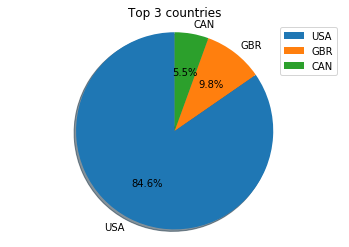

In [21]:
#pie chart showing top 3 countries in number of video games companies
top_countries = n_countries.head(3)
values = top_countries['Count']
labels = ['USA','GBR','CAN']

fig1, ax1 = plt.subplots()
ax1.pie(values,labels = labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
ax1.legend()
ax1.set_title('Top 3 countries')

In [6]:
#finding out which is the city where most of this companies are located -> New York

cities = []
    
for i in range(len(video_games)):
    try:
        company_city = video_games[i]['offices'][0]['city']
        cities.append(company_city)
    except:
        cities.append('no_data')


# transforming it to a data frame to get the top 3 cities  
cities = pd.DataFrame(cities)
cities['Count'] = 1

# Droping the unknown values
cities = cities[((cities[0] != 'no_data')&(cities[0] != '') )]

#Dataframe showing the top 3 cities
n_cities = cities.groupby([0]).count()
n_cities = n_cities.sort_values(by = ['Count'],ascending = False)
n_cities.head(3)

,Count
0,
New York,70
San Francisco,58
London,28


Text(0.5, 1.0, 'Top 3 cities')

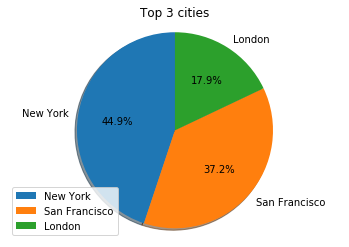

In [25]:
# pie chart showing top 3 cities in number of video games companies
top_cities = n_cities.head(3)
values = top_cities['Count']
labels = ['New York','San Francisco','London']

fig1, ax1 = plt.subplots()
ax1.pie(values,labels = labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
ax1.legend(loc='lower left')
ax1.set_title('Top 3 cities')

## Video games companies in New York

In [8]:
# companies of video games that are located in New York, not deadpooled and have coordinates included

games_ny = [
    {"$unwind": "$offices"},
    {"$match":{"$and": [{"offices.city":'New York'},
              {'category_code':'games_video'},
              {'offices.latitude':{'$ne':None}},
              {'offices.longitude':{'$ne':None}},
              {'deadpooled_year':None}]}}]

games_ny = list(coll.aggregate(games_ny))

In [9]:
# map with the offices of video games companies in New York
map_city = folium.Map(location=[40.730610,-73.935242], zoom_start=9)

for i in range(len(games_ny)):
    folium.Marker([games_ny[i]['offices']['latitude'],games_ny[i]['offices']['longitude']],
                    radius=2,
                    icon=folium.Icon(prefix='fa',icon='gamepad',color='blue'), 
                   ).add_to(map_city)
    
display(map_city)# there is one office which shouldn't be in the map

In [10]:
# storing the coordinates in the auxiliar collection
'''for place in games_ny:
    value = getLocation_offices(place,'Video_games')
    games_coll.insert_one(value)'''

In [11]:
#geoquery taking only the offices, which are really located in New York
games_ny =[]
games_ny = list(games_coll.find({'coordinates': {'$geoWithin': { '$centerSphere': 
            [ [ -73.97270658301223, 40.76453807477646 ], 0.0012475326124853252 ]}}}))

print(f'There are {len(games_ny)} offices of video games companies in New York.')

There are 45 offices of video games companies in New York.


In [12]:

map_city = folium.Map(location=[40.730610,-73.935242], zoom_start=12)

for i in range(len(games_ny)):
    folium.Marker([games_ny[i]['coordinates'][-1],games_ny[i]['coordinates'][0]],
                    radius=0.1,
                    icon=folium.Icon(prefix='fa',icon='gamepad',color='blue'), 
                   ).add_to(map_city)
display(map_city)

In [13]:
# storing the correct coordinates in the final collection
'''for e in games_ny:
    final_coll.insert_one(e)'''

## Companies founded before 2009

In [14]:
# companies founded before 2009 in New York, which have coordinates in the database and aren't closed

office_10 = [
    {"$unwind": "$offices"},
    {"$match":{"$and": [{"offices.city":'New York'},
              {'founded_year':{'$lt':2009}},
              {'offices.latitude':{'$ne':None}},
              {'offices.longitude':{'$ne':None}},
              {'deadpooled_year':None}
                       ]}}]

office_10 = list(coll.aggregate(office_10))       
            

In [15]:
#map with companies founded before 2009 in New York
map_city = folium.Map(location=[40.730610,-73.935242], zoom_start=1)

for i in range(len(office_10)):
    folium.Marker([office_10[i]['offices']['latitude'],office_10[i]['offices']['longitude']],
                    radius=0.5,
                    icon=folium.Icon(prefix='fa',icon='blind',color='red'), 
                   ).add_to(map_city)
    
#Note: there are offices outisde New York so it's necessary to perform a geoquery to erase them
display(map_city)

In [16]:
# storing the coordinates in the auxiliar database
'''for place in office_10:
    value = getLocation_offices(place,'Old companies')
    old_coll.insert_one(value)'''

In [17]:
# Geoquery for selecting the offices that are in New York using a polygon 

office_10 = list(old_coll.find({'coordinates': {'$geoWithin': { '$geometry': 
            { 'type': 'Polygon', 'coordinates': [ [ [ -73.96999075019157, 40.80715105959315 ],
            [ -73.93633235156877, 40.79000330835164 ], [ -73.98407232512561, 40.70263699912775 ],
            [ -74.02288251945599, 40.69665237044275 ], [ -74.02528669078619, 40.72604994282311 ], 
            [ -73.98063779465389, 40.80715105959315 ], [ -73.96999075019157, 40.80715105959315 ]] ] }}}}))


In [18]:
# map with companies founded before 2009 in New York
map_city = folium.Map(location=[40.730610,-73.935242], zoom_start=10)

for i in range(len(office_10)):
    folium.Marker([office_10[i]['coordinates'][-1],office_10[i]['coordinates'][0]],
                    radius=0.1,
                    icon=folium.Icon(prefix='fa',icon='blind',color='red'), 
                   ).add_to(map_city)
display(map_city)

In [19]:
# storing the correct coordinates in the final collection
'''for e in office_10:
    final_coll.insert_one(e)'''